# Weekly Status for WM

This notebook calculates some useful statistics for WM during a quarter.
Generally, each week, I just select "Restart Kernal and Run All Cells..." from the "Run" menu.

Below I'll note which output I think is most useful from each cell.  There is some stuff left over from developing/debugging the notebook too.  Sorry about that.

Finally, at the end of every quarter, I save the notebook, adding "-20XXQY" to the end of the notebook name so I have a record of the data from one quarter to the next.

# Boring Preliminaries
Note: you must have an up-to-date Github Personal Access Token stored in file "gh.tk" in the directory in which you run this notebook.  See cells in this section for details.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, timezone
from pprint import pprint
import math
from collections import Counter, defaultdict
import requests
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from zoneinfo import ZoneInfo
from pandas.api.types import CategoricalDtype

In [2]:
# Initialize the GH interface
# You should copy the value of your Github Personal Access Token into the file "gh.tk" in the same directory as this notebook
with open('gh.tk') as token_file:
    token = token_file.read().strip()

headers = {"Authorization": f"bearer {token}", "Accept": "application/vnd.github.starfox-preview+json"}

In [3]:
def run_query(query): # A simple function to use requests.post to make the API call. Note the json= section.
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}.\n Text: {}\nQueary: {}".format(request.status_code, request.text, query))

In [4]:
# This is a function for formatting table entries below
def make_issue_clickable(val):
    # target _blank to open new window
    return f'<a target="_blank" href="https://github.com/dmwm/WMCore/issues/{val}">#{val}</a>'

In [5]:
# These two (for datetime related things)
def format_timedelta(val):
    d = float(val.days) + val.seconds/(24*60*60)
    return f"{d:.1f} days"

def format_date(val):
    return val.strftime('%Y-%m-%d')

In [6]:
# How about one extracting first names to shorten the list of assignees
def format_name_list(val):
    names = val.split(',')
    firsts = [n.split(' ')[0] for n in names]
    return ', '.join(firsts)

# Quarter Parameters
Edit the start and end dates for the quarter.  The `plan_file` date is when we finally stopped adjusting the plan, so that we only pay attention to new issues added after that date.

In [7]:
# Relevant dates for the current quarter
qstart = datetime(2024,7,1,tzinfo=timezone.utc)
qend = datetime(2024,9,30, tzinfo=timezone.utc)
plan_final = datetime(2024,7,13, tzinfo=timezone.utc)
q_label = '2024 Q3'

# This is the project board
project_id = 6


# Running the actual query.
Very technical.  Only mess with if you know you need to.  Cells here produce a lot of debug output.  At the end of this block of cells, we have a pandas data frame with issue data in it.

In [8]:
# Now we need to pay attention to pagination limits

# Grab a timestamp of when the data is extracted
dt_query = datetime.now().astimezone(timezone.utc)

item_page_length = 50
item_pagination = f"first:{item_page_length}"
item_has_next_page = True
item_last_cursor = None
item_offset = 0

# Need pagination also on the fields
field_page_length = 15
field_pagination = f"first:{field_page_length}"
field_has_next_page = True
field_last_cursor = None

# And also on the labels
label_page_length = 10
label_pagination = f"first:{label_page_length}"
label_has_next_page = True
label_last_cursor = None

res = None

pages_loaded = 0
while (item_has_next_page or field_has_next_page or label_has_next_page):

    pages_loaded += 1
    
    # Let's make a query to get all the issues in a project
    query = f"""
    query {{
        organization(login:"dmwm") {{
            projectV2(number:{project_id}) {{
                items({item_pagination}) {{
                    nodes {{
                        fieldValues({field_pagination}) {{
                            nodes{{
                                __typename
                                ...on ProjectV2ItemFieldRepositoryValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    repository {{
                                        name
                                    }}
                                }}
                                ...on ProjectV2ItemFieldLabelValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    labels ({label_pagination}) {{
                                        pageInfo {{
                                            endCursor
                                            hasNextPage
                                        }}
                                        totalCount
                                        nodes {{
                                            name
                                        }}
                                    }}
                                }}
                                ...on ProjectV2ItemFieldTextValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    text
                                    updatedAt
                                }}
                                ...on ProjectV2ItemFieldSingleSelectValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2SingleSelectField {{
                                            name
                                        }}
                                    }}
                                    name
                                    optionId
                                    updatedAt
                                }}
                                ...on ProjectV2ItemFieldUserValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    users (first:10) {{
                                        nodes {{
                                            login
                                            name
                                        }}
                                    }}
                                }}
                                ...on ProjectV2ItemFieldPullRequestValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    pullRequests(last:5) {{
                                        nodes {{
                                            author {{
                                                login
                                            }}
                                            title
                                            number
                                        }}
                                    }}
                                }}
                                ...on ProjectV2ItemFieldMilestoneValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    milestone {{
                                        title
                                        createdAt
                                    }}
                                }}
                                ...on ProjectV2ItemFieldReviewerValue {{
                                    field {{
                                        __typename
                                        ...on ProjectV2Field {{
                                            name
                                        }}
                                    }}
                                    reviewers(last:5) {{
                                        nodes {{
                                            __typename
                                            ...on User {{                                                
                                                login
                                                name
                                            }}
                                        }}
                                    }}
                                }}
                            }}
                            totalCount
                            pageInfo {{
                                endCursor
                                hasNextPage
                            }}
                        }}
                        content {{
                            __typename
                            ...on Issue {{
                                title
                                number
                                createdAt
                                closed
                                closedAt
                                updatedAt
                                state
                                stateReason
                                trackedInIssues (last:1) {{
                                    nodes {{
                                        title
                                        number
                                    }}
                                }}
                            }}
                        }}
                        createdAt
                        updatedAt
                        isArchived
                        type
                    }}
                    totalCount
                    pageInfo {{
                        endCursor
                        hasNextPage
                    }}
                }}
            }}
        }}
    }}
    """
    r = run_query(query)

    if 'data' not in r:
        raise RuntimeError(f"Problem with GraphQL query:\n{r}")    
    
    item_cursor = r['data']['organization']['projectV2']['items']['pageInfo']['endCursor']
    item_has_next_page = r['data']['organization']['projectV2']['items']['pageInfo']['hasNextPage']
    field_has_next_page = False
    label_has_next_page = False
    field_cursor = ''
    label_cursor = ''
    for item in r['data']['organization']['projectV2']['items']['nodes']:
        field_has_next_page |= item['fieldValues']['pageInfo']['hasNextPage']
        if item['fieldValues']['pageInfo']['hasNextPage']:
            field_cursor = item['fieldValues']['pageInfo']['endCursor']
        for field in item['fieldValues']['nodes']:
            if 'labels' in field:
                label_has_next_page |= field['labels']['pageInfo']['hasNextPage']
                if field['labels']['pageInfo']['hasNextPage']:
                    label_cursor = field['labels']['pageInfo']['endCursor']

    if res == None:
        res = r['data']['organization']['projectV2']['items']['nodes']
    elif (field_cursor == field_last_cursor) and (item_cursor == item_last_cursor):
        for i, item in enumerate(r['data']['organization']['projectV2']['items']['nodes']):
            for j, field in enumerate(item['fieldValues']['nodes']):
                if 'labels' in field:
                    res[i+item_offset]['fieldValues']['nodes'][j+field_offset]['labels']['nodes'].extend(field['labels']['nodes'])
                    res[i+item_offset]['fieldValues']['nodes'][j+field_offset]['labels']['pageInfo'] = field['labels']['pageInfo']
    elif item_cursor == item_last_cursor:
        for i, item in enumerate(r['data']['organization']['projectV2']['items']['nodes']):
            res[i+item_offset]['fieldValues']['nodes'].extend(item['fieldValues']['nodes'])
            res[i+item_offset]['fieldValues']['pageInfo'] = item['fieldValues']['pageInfo']
    else:
        res.extend(r['data']['organization']['projectV2']['items']['nodes'])
    
    if label_has_next_page:
        # Go the next page of the labels field withotu changing the page of the fields or project items
        label_pagination = f'first:{label_page_length}, after:"{label_cursor}"'
    elif field_has_next_page:
        # Go to the next page of fields without changing the page of project items
        field_pagination = f'first:{field_page_length}, after:"{field_cursor}"'
        label_pagination = f"first:{label_page_length}"
        field_offset+=field_page_length
    else:
        field_pagination = f"first:{field_page_length}"
        label_pagination = f"first:{label_page_length}"
        item_pagination = f'first:{item_page_length}, after:"{item_cursor}"'
        field_offset = 0
        item_offset+=item_page_length
        
    item_last_cursor = item_cursor
    field_last_cursor = field_cursor
    label_last_cursor = label_cursor
    

print('#####################################')
print(f"{pages_loaded} pages loaded in query")
print(f"{len(res)} results retrieved")
print('  ==>Final result')
pprint(res[0:2])
field_types = set()
field_names = set()
for item in res:
    for field in item['fieldValues']['nodes']:
        typename = field['__typename']
        if 'field' in field:
            if 'name' in field['field']:
                field_names.add(field['field']['name'])
        if typename not in field_types:
            print(f"\n===>New field type {typename}")
            pprint(field)
        field_types.add(typename)
print('\n\n####################################')
print('Field types:')
pprint(field_types)
print('\n\n####################################')
print('Field names:')
pprint(field_names)

#####################################
8 pages loaded in query
400 results retrieved
  ==>Final result
[{'content': {'__typename': 'Issue',
              'closed': False,
              'closedAt': None,
              'createdAt': '2022-06-22T20:16:40Z',
              'number': 11192,
              'state': 'OPEN',
              'stateReason': None,
              'title': 'Replace replicator filters by selector objects',
              'trackedInIssues': {'nodes': []},
              'updatedAt': '2022-06-22T20:16:57Z'},
  'createdAt': '2022-06-29T02:24:25Z',
  'fieldValues': {'nodes': [{'__typename': 'ProjectV2ItemFieldRepositoryValue',
                             'field': {'__typename': 'ProjectV2Field',
                                       'name': 'Repository'},
                             'repository': {'name': 'WMCore'}},
                            {'__typename': 'ProjectV2ItemFieldLabelValue',
                             'field': {'__typename': 'ProjectV2Field',
               

In [9]:
# Grab the timestamp for when the dataframe was created
dt_dfcreated = datetime.now()

# Make a data frame with an entry for each issue
issue_data = {'num':[], 'added':[], 'closed':[], 'updated':[], 'category':[], 'qprio':[], 'qtheme':[], 'stakeholder':[],
              'status':[], 'status_updated':[], 'assignees':[], 'title':[],}

# Now, let's loop over the list of issues and fill the necessary items fields
for issue in res:
    if issue['content']['__typename'] != 'Issue':
        # Skipping things that aren't issues
        continue

    # Pull out some field values
    category = None
    qprio = None
    qtheme = None
    stakeholder = None
    meta = None
    status = None
    status_updated = None
    assignees = None
    this_quarter = False
    added = datetime.fromisoformat(issue['content']['createdAt'])
    for field in issue['fieldValues']['nodes']:
        if field['field']['name'] == 'Quarter':
            if field['name'] == q_label:
                this_quarter = True
                d = datetime.fromisoformat(field['updatedAt'])
                if d > added:
                    added = d
            else:
                # No point in finishing this loop
                break
        
        if field['field']['name'] == 'Category':
            category = field['name']
        
        if field['field']['name'] == 'Stakeholder':
            stakeholder = field['name']
            
        if field['field']['name'] == 'Q Prio':
            qprio = field['name']

        if field['field']['name'] == 'Q Theme':
            qtheme = field['name']

        if field['field']['name'] == 'Status':
            status = field['name']
            # We only count as closed things that were closed because they are COMPLETED
            if (issue['content']['state'] == 'CLOSED') and (issue['content']['stateReason'] == 'NOT_PLANNED'):
                status = 'Dropped'
            d = datetime.fromisoformat(field['updatedAt'])
            status_updated = d
        if field['field']['name'] == 'Assignees':
            atemp = []
            for a in field['users']['nodes']:
                n = a['name']
                if n == None:
                    n = a['login']
                atemp.append(n)
            assignees = ','.join(atemp)

#    if 'trackedInIssues' in issue['content']:
#        print(issue['content']['trackedInIssues'])
    
    # Only count issues from this quarter and skip meta issues
    if this_quarter and qprio != 'Meta':
        issue_data['num'].append(int(issue['content']['number']))

        if added < qstart:
            added = qstart
        
        issue_data['added'].append(added)
        issue_data['updated'].append(datetime.fromisoformat(issue['content']['updatedAt']))
        # We only count as closed things that were closed because they are COMPLETED
        if issue['content']['closed'] and (issue['content']['stateReason'] != 'NOT_PLANNED'):
            issue_data['closed'].append(datetime.fromisoformat(issue['content']['closedAt']))
        else:
            issue_data['closed'].append(None)
        issue_data['category'].append(category)
        issue_data['stakeholder'].append(stakeholder)
        issue_data['qprio'].append(qprio)
        issue_data['qtheme'].append(qtheme)
        issue_data['status'].append(status)
        issue_data['status_updated'].append(status_updated)
        issue_data['assignees'].append(assignees)
        issue_data['title'].append(issue['content']['title'])

for field in issue_data:
    print(f"{field}: {len(issue_data[field])}")

num: 54
added: 54
closed: 54
updated: 54
category: 54
qprio: 54
qtheme: 54
stakeholder: 54
status: 54
status_updated: 54
assignees: 54
title: 54


In [10]:
df = pd.DataFrame(issue_data)
pprint(df['category'].unique())
pprint(df['qprio'].unique())
pprint(df['qtheme'].unique())
pprint(df['stakeholder'].unique())
df[0:3].style

array(['R&D', 'New feature', 'Feature change', 'Technical debt',
       'Documentation/Training', 'Refactoring', 'Operations', 'Bug'],
      dtype=object)
array(['R&D', 'Operations', 'High', 'Low', 'Medium'], dtype=object)
array(['Planning', None, 'Token Authentication', 'Technology Migration',
       'Education', 'New Microservices', 'WM Containerization',
       'Resiliency/Reliability', 'Operational Usability',
       'SiteList Updates'], dtype=object)
array(['DM', 'P&R', 'SI', 'WM', 'CMSWEB', 'CMS', 'SST', 'T0'],
      dtype=object)


,num,added,closed,updated,category,qprio,qtheme,stakeholder,status,status_updated,assignees,title
0,11409,2024-07-08 19:09:00+00:00,NaT,2024-07-12 18:46:13+00:00,R&D,R&D,Planning,DM,ToDo,2022-12-19 02:58:31+00:00,nhduongvn,CDR: continuous input data removal for active workflows
1,11508,2024-07-01 00:00:00+00:00,NaT,2024-06-11 02:27:59+00:00,New feature,Operations,None,P&R,ToDo,2023-03-09 19:12:54+00:00,None,ACDC failures due to missing policy args - DQMHarvest not supported
2,11594,2024-07-08 14:46:17+00:00,NaT,2024-01-22 14:22:50+00:00,R&D,R&D,None,SI,In Progress,2024-01-22 14:22:54+00:00,Kenyi Hurtado,Investigate usage of job sets at agent job submission level for matchmaking of specific workflows with heterogeneous resources


In [11]:
# categorical type for each week.  This will let us have empty weeks, I think

# Start by figuring out how many weeks to plot.  The +1 is because the start and end dates are assumed to be inclusive.
nweeks = math.ceil(((dt_query-qstart).days+1)/7)
week_list = []
for i in range(nweeks):
    week_list.append((qstart+timedelta(i*7)).date().isoformat())

qweek_type = CategoricalDtype(categories=week_list, ordered=True)
qweek_type

CategoricalDtype(categories=['2024-07-01', '2024-07-08', '2024-07-15'], ordered=True, categories_dtype=object)

# Issues closed per week

**This is one of our most important plots.**

Doesn't align with M through Su weeks or anything else.  It's just every 7 days starting in the first day of the quarter.

Don't miss the printout with the number of issues closed.

Current average rate of issues closing: 1.0 ± 1.0


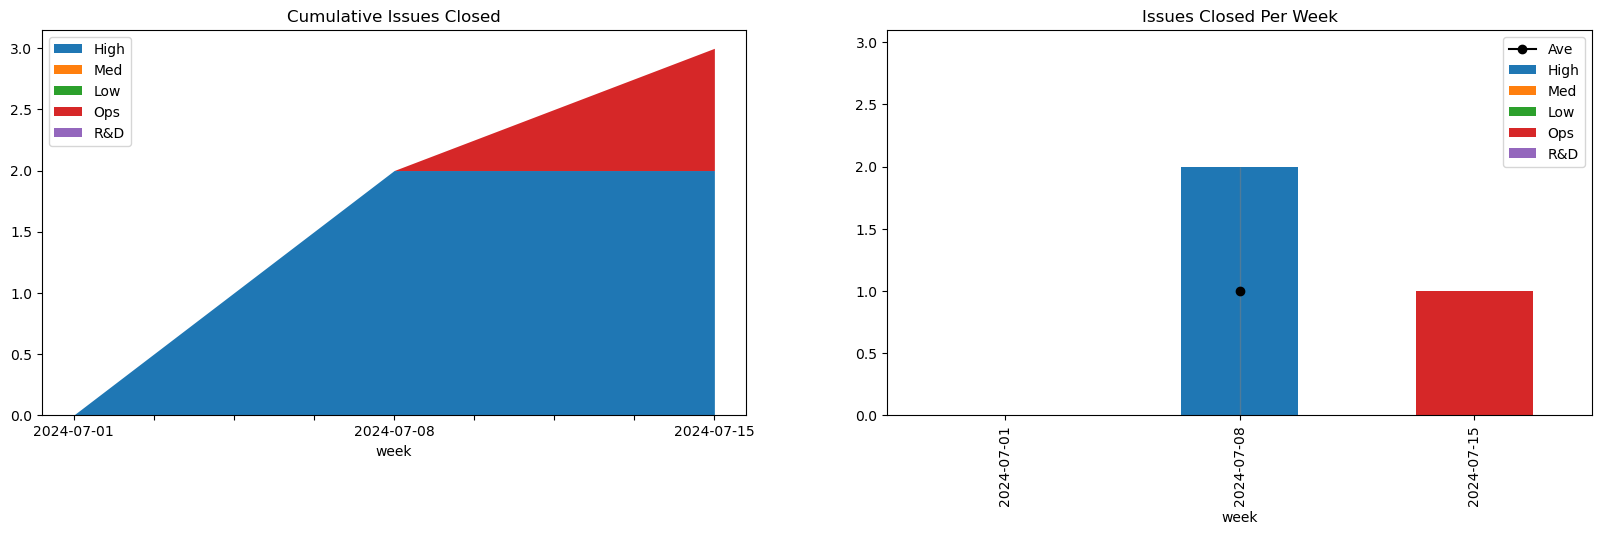

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

# Calculate the numbers
closed_qprio = df[~df['closed'].isna()][['closed','qprio','category','assignees']].sort_values('closed').set_index('closed')
closed_qprio['High'] = (closed_qprio['qprio'] == 'High')
closed_qprio['Med'] = (closed_qprio['qprio'] == 'Medium')
closed_qprio['Low'] = (closed_qprio['qprio'] == 'Low')
closed_qprio['Ops'] = (closed_qprio['qprio'] == 'Operations')
closed_qprio['R&D'] = (closed_qprio['qprio'] == 'R&D')

# Add a column to count the weeks and group by it
closed_qprio['week'] = pd.Categorical.from_codes((closed_qprio.index - qstart).days//7,categories=qweek_type.categories).astype(qweek_type)
c = closed_qprio[['High','Med','Low','Ops','R&D','week']].groupby('week', observed=False).sum()

# Plot the cumulative work done
c[['High','Med','Low','Ops','R&D']].cumsum().plot.area(linewidth=0, ax=ax[0])
ax[0].set_title('Cumulative Issues Closed')
# Plot the work done each week
c[['High','Med','Low','Ops','R&D']].plot.bar(linewidth=0,stacked=True,ax=ax[1])

# Figure out the averages
# Let's try to extract some information about our weekly close rate
weekly_closed = c[['High','Med','Low','Ops','R&D']].sum(axis=1)
# Can't make use of a week where fewer than 6 days already having passed
days_in_last_week = (dt_query-qstart-timedelta((len(weekly_closed)-1)*7)).days+1
if days_in_last_week < 6:
    weekly_closed = weekly_closed[:-1]
rolling_ave = weekly_closed.expanding().mean()
rolling_ave.iloc[0] = np.nan  # This takes this point out of the plot
rolling_std = weekly_closed.expanding().std()
rolling_err = rolling_std/np.sqrt(weekly_closed.expanding().count())
ax[1].fill_between(rolling_ave.index,rolling_ave+rolling_err, rolling_ave-rolling_err, alpha=0.5, color='gray')
ax[1].plot(rolling_ave.index, rolling_ave.values,label='Ave',color='black',marker='o')
ax[1].set_ylim((ax[1].get_ylim()[0],ax[1].get_ylim()[1]+1))
ax[1].set_title('Issues Closed Per Week')
ax[1].legend()

print(f"Current average rate of issues closing: {rolling_ave.iloc[-1]:.1f} ± {rolling_err.iloc[-1]:.1f}")


# Issues Added

This isn't as important.  It captures when issues have been added.  The data is used later in calculating the budget.  Note, the printed average is `NaN` until we have one week of issues accumulated since the "Plan Finalized" date.

Current average rate of issues added: nan +- 0.0


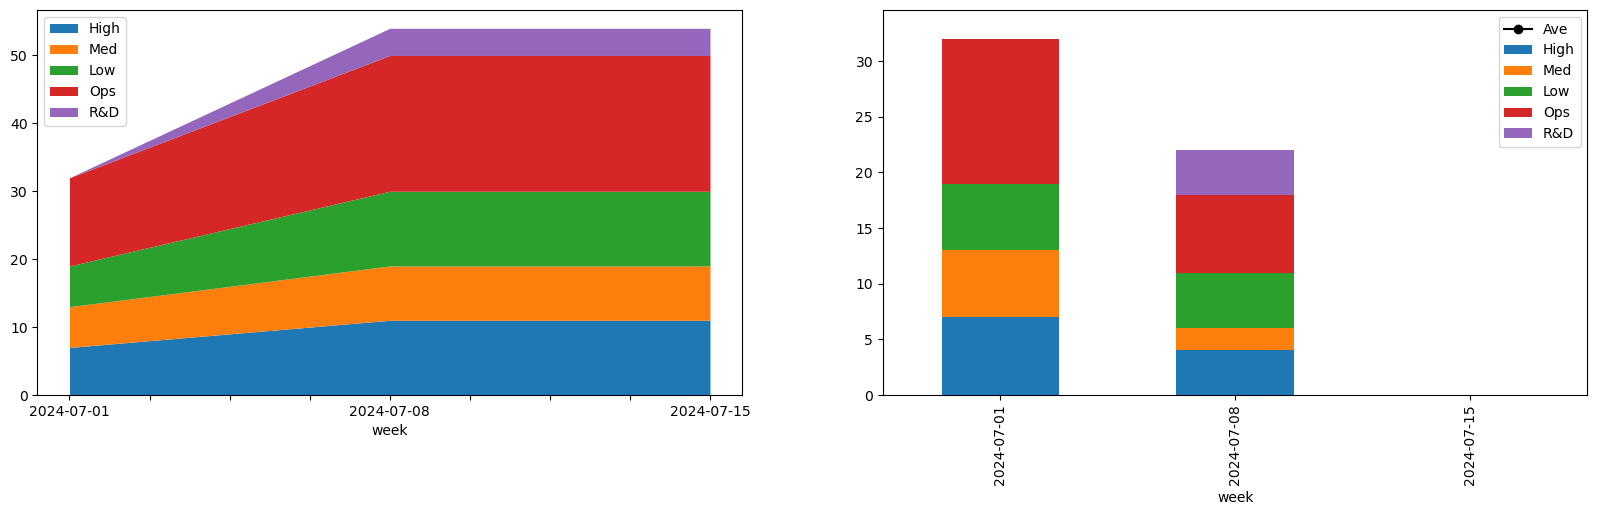

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

# Calculate the numbers
added_qprio = df[~df['added'].isna()][['added','qprio','category']].sort_values('added').set_index('added')
added_qprio['High'] = (added_qprio['qprio'] == 'High')
added_qprio['Med'] = (added_qprio['qprio'] == 'Medium')
added_qprio['Low'] = (added_qprio['qprio'] == 'Low')
added_qprio['Ops'] = (added_qprio['qprio'] == 'Operations')
added_qprio['R&D'] = (added_qprio['qprio'] == 'R&D')

# Add a column to count the weeks and group by it
added_qprio['week'] = pd.Categorical.from_codes((added_qprio.index - qstart).days//7,categories=qweek_type.categories).astype(qweek_type)
aa = added_qprio[['High','Med','Low','Ops','R&D','week']].groupby('week', observed=False).sum()

# Plot the cumulative work added (including things from the start of the quarter)
aa[['High','Med','Low','Ops','R&D']].cumsum().plot.area(linewidth=0, ax=ax[0])

# Plot the work done each week 
aa[['High','Med','Low','Ops','R&D']].plot.bar(linewidth=0,stacked=True,ax=ax[1])

# Figure out the averages
# Let's try to extract some information about our weekly close rate
weekly_added = aa[['High','Med','Low','Ops','R&D']].sum(axis=1)
# Can't make use of a week where fewer than 6 days already having passed
days_in_last_week = (dt_query-qstart-timedelta((len(weekly_added)-1)*7)).days+1
if days_in_last_week < 6:
    weekly_added = weekly_added[:-1]

#Skip weeks that are before the quarter planning finished.
fweek = (plan_final - qstart).days//7

rolling_ave = np.full_like(weekly_added,np.nan,dtype=float)
rolling_ave[fweek+1:] = weekly_added[fweek+1:].expanding().mean()
rolling_std = np.zeros_like(weekly_added,dtype=float)
rolling_err = np.zeros_like(weekly_added,dtype=float)
if len(weekly_added[fweek+1:])>1:
    rolling_std[fweek+1:] = weekly_added[fweek+1:].expanding().std()
    rolling_err[fweek+1:] = rolling_std[fweek+1:]/np.sqrt(weekly_added[fweek+1:].expanding().count())
ax[1].fill_between(weekly_added.index,rolling_ave+rolling_err, rolling_ave-rolling_err, alpha=0.5, color='gray')
ax[1].plot(weekly_added.index, rolling_ave,label='Ave',color='black',marker='o')
ax[1].set_ylim((ax[1].get_ylim()[0],ax[1].get_ylim()[1]+1))
ax[1].legend()

print(f"Current average rate of issues added: {rolling_ave[-1]:.1f} +- {rolling_err[-1]:.1f}")


# Issues by Quarter Priority

**This is an important plot**

This table/pie chart shows issues in progress, waiting, and closed by priority.  Generally, we don't want to see activity in the lower priorities before "High" and "Operations" well under control.

,Total,WIP,Waiting,Closed,Fraction
Quarterly Priority,,,,,
High,11,3,0,2,18.2%
Low,11,0,0,0,0.0%
Medium,8,0,0,0,0.0%
Operations,20,11,1,1,5.0%
R&D,4,2,0,0,0.0%


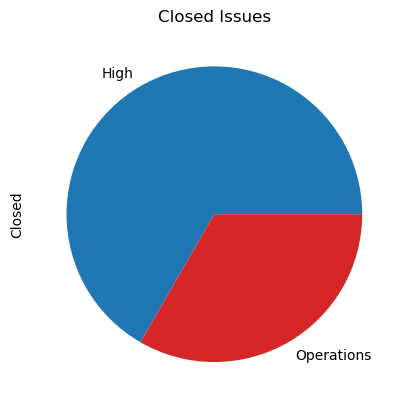

In [14]:
df['isClosed'] = ~df['closed'].isna()
df['isWIP'] = (df['status']=='In Progress')
df['isWaiting'] = (df['status']=='Waiting')
df['isTodo'] = (df['status']=='ToDo')
df['Quarterly Priority'] = df['qprio']
df['Quarterly Priority'] = df['Quarterly Priority'].fillna('Operations')
df.style
summary = df[df['Quarterly Priority']!='Meta'][['isClosed','isWIP','isWaiting','Quarterly Priority']].groupby('Quarterly Priority').agg(Total=pd.NamedAgg(column="isClosed", aggfunc="count"),
                                                      WIP=pd.NamedAgg(column="isWIP", aggfunc="sum"),
                                                      Waiting=pd.NamedAgg(column="isWaiting", aggfunc="sum"),
                                                      Closed=pd.NamedAgg(column="isClosed", aggfunc="sum"),
                                                    )
                                                        
summary['Fraction'] = summary['Closed']/summary['Total']*100
#display(summary.loc[['High','Medium','Low','Operations','R&D']].style.format(formatter=({'Fraction':'{:.1f}%'})))
display(summary.style.format(formatter=({'Fraction':'{:.1f}%'})))
summary['Closed'].plot.pie(title='Closed Issues', xlabel='-');

# Issues Assigned

**This is an important table!**

This shows how the work is being divided among the team.Watch for people who have too much WIP and are causing a bottleneck.  Watch also for team members who aren't closing many issues compared to their FTE on project to see if they can be better engaged.

In [15]:
summary2 = df[(df['Quarterly Priority']!='Meta')&(df['Quarterly Priority']!='R&D')][['isTodo','isClosed','isWIP','isWaiting','assignees']].groupby('assignees').agg(#Total=pd.NamedAgg(column="isClosed", aggfunc="count"),
                                                      Todo=pd.NamedAgg(column="isTodo", aggfunc="sum"),
                                                      WIP=pd.NamedAgg(column="isWIP", aggfunc="sum"),
                                                      Waiting=pd.NamedAgg(column="isWaiting", aggfunc="sum"),
                                                      Closed=pd.NamedAgg(column="isClosed", aggfunc="sum"),
                                                    )
def_cols = {}
cols = ['Todo','WIP','Waiting','Closed']
# Change the column types for the relecvant columns
for col in cols:
    summary2[col]=summary2[col].astype(float)
    def_cols[col] = [0]
rows_to_drop = []
for i in range(len(summary2)):
    assignees = summary2.index[i] 
    if ',' in assignees:
        names = assignees.split(',')
        nsplit = len(names)
        for n in names:
            if n not in summary2.index:
                summary2 = pd.concat([summary2, pd.DataFrame(def_cols, index=[n])])
            for col in cols:
                summary2.loc[n,col] += summary2.iloc[i][col]/nsplit
        rows_to_drop.append(assignees)
if len(rows_to_drop)>0:
    summary2 = summary2.drop(rows_to_drop)
display(summary2[summary2[cols].sum(axis=1)>0].style.format(precision=2))
#summary2['Closed'].plot.pie(title='Closed Issues', xlabel='-');

,Todo,WIP,Waiting,Closed
Alan Malta Rodrigues,0.50,5.17,0.00,0.00
Dennis Lee,0.50,1.33,0.00,0.50
Kenyi Hurtado,0.00,0.33,1.00,0.00
Todor Ivanov,0.00,3.00,0.00,2.50
Valentin Kuznetsov,0.00,2.50,0.00,0.00
Andrea Piccinelli,0.00,1.33,0.00,0.00
Muhammad Hassan Ahmed,0.00,0.33,0.00,0.00


# WIP/Waiting Issues: Full details

This has the full details of issues that are in progress or waiting.

In [16]:
#df[((df['status'] == 'In Progress')|(df['status'] == 'Waiting'))&(df['Quarterly Priority']=='High')][['num','title','status','stakeholder','status_updated','Quarterly Priority','qtheme','assignees','category']].sort_values(by='status_updated').style
df_wip = df[((df['status'] == 'In Progress')|(df['status'] == 'Waiting'))]
dt_today = datetime.now().astimezone(timezone.utc)
df_wip.loc[:,('Time WIP',)] = (dt_today-df_wip['status_updated'])
df_wip[['num','title','status','stakeholder','status_updated','Time WIP','updated','Quarterly Priority','qtheme','assignees','category']].sort_values(by='status_updated').style.hide().format({'num': make_issue_clickable})

num,title,status,stakeholder,status_updated,Time WIP,updated,Quarterly Priority,qtheme,assignees,category
#11594,Investigate usage of job sets at agent job submission level for matchmaking of specific workflows with heterogeneous resources,In Progress,SI,2024-01-22 14:22:54+00:00,175 days 10:01:00.130435,2024-01-22 14:22:50+00:00,R&D,None,Kenyi Hurtado,R&D
#11860,Refresh test json templates due to removal of input data,In Progress,WM,2024-03-26 19:43:18+00:00,111 days 04:40:36.130435,2024-03-26 19:43:13+00:00,Operations,None,Alan Malta Rodrigues,Operations
#11742,R&D Investigate on pilot lifetime projected onto HL-LHC era,In Progress,WM,2024-03-28 01:35:10+00:00,109 days 22:48:44.130435,2024-04-08 12:52:16+00:00,R&D,Planning,Alan Malta Rodrigues,R&D
#11965,Agents continuously failing to insert blocks into DBS,In Progress,WM,2024-04-11 16:20:11+00:00,95 days 08:03:43.130435,2024-04-11 16:20:06+00:00,Operations,None,Todor Ivanov,Operations
#11970,MSUnmerged: Test certificate issues and re-enable the service at T2_CH_CERN,In Progress,WM,2024-04-18 11:08:14+00:00,88 days 13:15:40.130435,2024-05-13 11:27:14+00:00,Operations,None,Todor Ivanov,Operations
#11568,Update Jenkins WMCore baseline and PR-test to run based on WMAgent/CouchDB/MariaDB containers,In Progress,WM,2024-05-02 20:13:51+00:00,74 days 04:10:03.130435,2024-06-03 14:58:21+00:00,High,WM Containerization,"Alan Malta Rodrigues,Kenyi Hurtado,Dennis Lee",Technical debt
#11960,WMArchive Grafana Monitoring Down / No Data,In Progress,P&R,2024-05-06 11:26:01+00:00,70 days 12:57:53.130435,2024-04-24 14:08:19+00:00,Operations,None,Valentin Kuznetsov,Bug
#11978,Create a WMAgent/WMCore-dev image to run unittests,In Progress,WM,2024-05-16 19:55:31+00:00,60 days 04:28:23.130435,2024-06-01 12:04:22+00:00,High,WM Containerization,Dennis Lee,Technical debt
#11997,Update dmwm-base and wmagent-base docker images,In Progress,WM,2024-05-24 15:52:24+00:00,52 days 08:31:30.130435,2024-05-31 01:19:03+00:00,Operations,Resiliency/Reliability,Alan Malta Rodrigues,Operations
#11762,Implement policy to release stable releases,In Progress,CMSWEB,2024-05-29 14:45:00+00:00,47 days 09:38:54.130435,2024-07-03 02:24:45+00:00,Operations,None,Valentin Kuznetsov,Feature change


# Cut-and-Paste-able Simple WIP/Waiting Tables

**This is important**

## High Priority

In [17]:
df_wip_high = df_wip[(df_wip['Quarterly Priority']=='High')&(df_wip['Time WIP']>timedelta(days=14))].sort_values(by='status_updated').rename(columns = {'num':'Issue','title':'Title',
                                                                                                              'status':'Status',
                                                                                                              'Time WIP':'Time in Status',
                                                                                                              'updated':'Last Updated', 
                                                                                                              'qtheme':'Theme',
                                                                                                              'assignees':'Assignees'})
display(HTML('<h2>High Priority Issues Open More Than 2 Weeks</h2>'))
display(df_wip_high[['Issue','Status','Time in Status','Last Updated','Assignees']].style.hide().format({'Issue': make_issue_clickable,
                                                                                                                 'Time in Status':format_timedelta,
                                                                                                                 'Last Updated':format_date,
                                                                                                                 'Assignees':format_name_list
                                                                                                                 }))

Issue,Status,Time in Status,Last Updated,Assignees
#11568,In Progress,74.2 days,2024-06-03,"Alan, Kenyi, Dennis"
#11978,In Progress,60.2 days,2024-06-01,Dennis
#12023,In Progress,24.4 days,2024-06-21,Todor


## Operations

In [18]:
df_wip_high = df_wip[(df_wip['Quarterly Priority']=='Operations')&(df_wip['Time WIP']>timedelta(days=14))].sort_values(by='status_updated').rename(columns = {'num':'Issue','title':'Title',
                                                                                                              'status':'Status',
                                                                                                              'Time WIP':'Time in Status',
                                                                                                              'updated':'Last Updated', 
                                                                                                              'qtheme':'Theme',
                                                                                                              'assignees':'Assignees'})
display(HTML('<h2>Operations Issues Open More Than 2 Weeks</h2>'))
display(df_wip_high[['Issue','Status','Time in Status','Last Updated','Assignees']].style.hide().format({'Issue': make_issue_clickable,
                                                                                                                 'Time in Status':format_timedelta,
                                                                                                                 'Last Updated':format_date,
                                                                                                                 'Assignees':format_name_list,
                                                                                                                 }))

Issue,Status,Time in Status,Last Updated,Assignees
#11860,In Progress,111.2 days,2024-03-26,Alan
#11965,In Progress,95.3 days,2024-04-11,Todor
#11970,In Progress,88.6 days,2024-05-13,Todor
#11960,In Progress,70.5 days,2024-04-24,Valentin
#11997,In Progress,52.4 days,2024-05-31,Alan
#11762,In Progress,47.4 days,2024-07-03,Valentin
#12022,In Progress,25.1 days,2024-06-20,Alan
#12026,In Progress,18.3 days,2024-07-12,"Valentin, Alan"


# Summary of Closed Issues

In [19]:
closed_df = df[df['isClosed']][['num','title','closed','qprio','qtheme','status','status_updated','assignees','category']]
closed_df.sort_values(by='status_updated').style.hide().format({'num': make_issue_clickable})

num,title,closed,qprio,qtheme,status,status_updated,assignees,category
#12007,MariaDB container 10.6.5 issues (slowness and deadlock),2024-07-08 19:35:17+00:00,High,WM Containerization,Done,2024-07-08 19:35:19+00:00,"Todor Ivanov,Dennis Lee",Bug
#12034,etc/rucio.cfg gets misconfigured upon WMAgent tag update,2024-07-09 12:54:18+00:00,High,WM Containerization,Done,2024-07-09 12:54:19+00:00,Todor Ivanov,Bug
#12036,Clarify the job logging procedure,2024-07-15 12:38:58+00:00,Operations,None,Done,2024-07-15 12:39:02+00:00,Todor Ivanov,Operations


# Summary of Issues in To-Do state

In [20]:
df[(df['status'] == 'ToDo')][['num','title','status','status_updated','Quarterly Priority','qtheme','assignees','category']].sort_values(by='num').style

,num,title,status,status_updated,Quarterly Priority,qtheme,assignees,category
0,11409,CDR: continuous input data removal for active workflows,ToDo,2022-12-19 02:58:31+00:00,R&D,Planning,nhduongvn,R&D
1,11508,ACDC failures due to missing policy args - DQMHarvest not supported,ToDo,2023-03-09 19:12:54+00:00,Operations,None,None,New feature
3,11728,Adopt generic token in the MSUnmerged service,ToDo,2023-09-22 01:34:10+00:00,High,Token Authentication,None,New feature
44,11731,WMCore stage-out script improvement,ToDo,2024-07-03 02:31:23+00:00,High,Token Authentication,None,New feature
4,11739,Finalize WM projection results,ToDo,2023-10-09 13:14:07+00:00,R&D,Planning,Alan Malta Rodrigues,R&D
11,11823,Create new repository and basic repo structure for the new generation of microservices,ToDo,2024-01-22 15:09:34+00:00,Low,New Microservices,None,New feature
12,11824,Create CI pipeline for the new generation of microservices,ToDo,2023-12-21 19:50:18+00:00,Low,New Microservices,None,New feature
13,11825,Create CD pipeline for the new generation of microservices,ToDo,2023-12-21 19:50:38+00:00,Low,New Microservices,None,New feature
14,11826,Create HTTP core functionality for the new generation of microservices,ToDo,2023-12-21 19:51:05+00:00,Low,New Microservices,None,New feature
15,11827,Create core /status REST endpoint for the new generation of microservices,ToDo,2023-12-21 19:51:31+00:00,Low,New Microservices,None,New feature


# Extrapolating current quarter metrics into next quarter.

**This is an important cell to pay attention to as quarter progresses.**

In [21]:
# Let's calculate without R&D
weekly_closed_nord = c[['High','Med','Low','Ops']].sum(axis=1)

# Can't make use of a week where fewer than 6 days already having passed
days_in_last_week = (dt_query-qstart-timedelta((len(weekly_closed_nord)-1)*7)).days+1
if days_in_last_week < 6:
    weekly_closed_nord = weekly_closed_nord[:-1]

weekly_ave = weekly_closed_nord.expanding().mean().iloc[1:].iloc[-1]
weekly_rms = weekly_closed_nord.expanding().std().iloc[1:].iloc[-1]
weekly_err = weekly_rms/np.sqrt(weekly_closed_nord.expanding().count()).iloc[1:].iloc[-1]
print(f"Weekly average = {weekly_ave:.1f} ± {weekly_err:.1f}")

# Alternative calculation of issues
total_closed_this_q = weekly_closed_nord.sum()
print(f"Total issues closed this quarter (no R&D): {total_closed_this_q}")

q_weeks = 12

# How far are we through the quarter
t_today = dt_query - qstart
t_quarter = qend - qstart
q_fraction = t_today/t_quarter
if q_fraction > 1:
    q_fraction = 1

print(f"Fraction of quarter completed so far = {q_fraction*100:.1f}%")

capacity = weekly_ave * q_weeks
cap_sys  = weekly_err * q_weeks
cap_stat = math.sqrt(weekly_rms**2 * q_weeks)
cap_err  = math.sqrt(cap_sys**2+cap_stat**2)
print(f"Capacity = {capacity:.1f} ± {cap_err:.1f}")

# Adjustments to the plan

# Operational issues
ops_n = summary['Closed']['Operations']
print(f"Operation issues closed this quarter = {ops_n}")
# Adjust for how far through the quarter we are
ops_n /= q_fraction
ops_err = math.sqrt(ops_n)
print(f"Operational Issues = {ops_n:.1f} ± {ops_err:.1f}")

dev_n = capacity - ops_n
dev_err = math.sqrt(cap_err**2 + ops_err**2)
print(f"Development Capacity (Ops subtracted) = {dev_n:.1f} ± {dev_err:.1f}")

# Growth in number of issues
# Figure out the averages
# Let's try to extract some information about our weekly close rate
newly_added = aa[['High','Med','Low']].sum(axis=1)
# Can't make use of a week where fewer than 6 days already having passed
if days_in_last_week < 6:
    newly_added = newly_added[:-1]
    
preplanned = newly_added[:fweek+1].sum()
added_later = newly_added[fweek+1:].sum()

planning_factor = preplanned/(added_later+preplanned)
print(f"Planning Factor = {100*planning_factor:.1f}%")

# Just carrying this over from last year.  Normally take it from the Q by Q variation
planning_factor_err = 0.12

# Budget = (capacity-ops_n)*planning_factor
budget = dev_n * planning_factor
budget_err = math.sqrt((dev_err * planning_factor)**2+(dev_n*planning_factor_err)**2)
print(f"Budget = {budget:.1f} ± {budget_err:.1f}")


Weekly average = 1.0 ± 1.0
Total issues closed this quarter (no R&D): 2
Fraction of quarter completed so far = 16.5%
Capacity = 12.0 ± 13.0
Operation issues closed this quarter = 1
Operational Issues = 6.1 ± 2.5
Development Capacity (Ops subtracted) = 5.9 ± 13.2
Planning Factor = 100.0%
Budget = 5.9 ± 13.2


# High Level Summary of the Plan
These are summary tables useful for providing a high level summary of how we're doing on the plan.

In [22]:
summary_gdoc = df[df['qprio']=='High'][['isClosed','isWIP','isWaiting','qtheme']].groupby('qtheme').agg(Total=pd.NamedAgg(column="isClosed", aggfunc="count"),
                                                                                                        WIP=pd.NamedAgg(column="isWIP", aggfunc="sum"),
                                                                                                        Waiting=pd.NamedAgg(column="isWaiting", aggfunc="sum"),
                                                                                                        Closed=pd.NamedAgg(column="isClosed", aggfunc="sum"),
                                                                                                       )
summary_gdoc.index.names = ['Theme']
summary_gdoc.loc['All Themes'] = summary_gdoc.sum(numeric_only=True)
summary_temp = df[df['qprio']=='Operations'][['isClosed','isWIP','isWaiting','qprio']].groupby('qprio').agg(Total=pd.NamedAgg(column="isClosed", aggfunc="count"),
                                                                                                                                   WIP=pd.NamedAgg(column="isWIP", aggfunc="sum"),
                                                                                                                                   Waiting=pd.NamedAgg(column="isWaiting", aggfunc="sum"),
                                                                                                                                   Closed=pd.NamedAgg(column="isClosed", aggfunc="sum"),
                                                                                                                                  )
summary_temp.index.names = ['Theme']
summary_gdoc = pd.concat([summary_gdoc,summary_temp])
summary_gdoc['% Complete'] = summary_gdoc['Closed']/summary_gdoc['Total']
display(HTML('<p>For full details on individual issues, please see the <a href="https://github.com/orgs/dmwm/projects/6/views/11">Github Project Board</href>.'))
t_today =  dt_query - qstart
t_quarter = qend - qstart
q_fraction = t_today/t_quarter
display(HTML(f'<p>Summary table generated on {dt_query.astimezone().strftime("%a %d-%b-%Y at %H:%M:%S %Z")} ({q_fraction*100:.1f}% through quarter).'))
display(summary_gdoc.style.format({'% Complete':'{:.1%}'}))

,Total,WIP,Waiting,Closed,% Complete
Theme,,,,,
SiteList Updates,4,0,0,0,0.0%
Token Authentication,2,0,0,0,0.0%
WM Containerization,5,3,0,2,40.0%
All Themes,11,3,0,2,18.2%
Operations,20,11,1,1,5.0%


In [23]:
stakeholder_table = df[df['qprio']=='High'][['isClosed','isWIP','isWaiting','stakeholder']].groupby('stakeholder').agg(Total=pd.NamedAgg(column="isClosed", aggfunc="count"),
                                                                                                                      WIP=pd.NamedAgg(column="isWIP", aggfunc="sum"),
                                                                                                                      Waiting=pd.NamedAgg(column="isWaiting", aggfunc="sum"),
                                                                                                                      Closed=pd.NamedAgg(column="isClosed", aggfunc="sum"),
                                                                                                                      )
stakeholder_table.index.names = ['Stakeholders']
stakeholder_table['% Complete'] = stakeholder_table['Closed']/stakeholder_table['Total']
display(stakeholder_table.style.format({'% Complete':'{:.1%}'}))

,Total,WIP,Waiting,Closed,% Complete
Stakeholders,,,,,
P&R,4,0,0,0,0.0%
SST,1,0,0,0,0.0%
WM,6,3,0,2,33.3%
